In [2]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

In [3]:
import gym
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from q_learning import plot_running_avg, FeatureTransformer

In [5]:
# so you can test different architectures
class HiddenLayer:
    def __init__(self, M1, M2, f=tf.nn.tanh, use_bias= True, zeros= False):
        if zeros:
            W = np.zeros((M1, M2)).astype(np.float32)
            self.W = tf.Variable(W)
        else: 
            self.W = tf.Variable(tf.random_normal(shape = (M1, M2)))

        self.params = [self.W]
        self.use_bias = use_bias
        if use_bias:
            self.b = tf.Variable(np.zeros(M2).astype(np.float32))
            self.params.append(self.b)
        self.f = f
    
    def forward(self, X):
        if self.use_bias:
            a = tf.matmul(X, self.W) + self.b
        else:
            a = tf.matmul(X, self.W)
        return self.f(a)

In [16]:
# approximates pi(a | s)
class PolicyModel:
    def __init__(self, ft, D, hidden_layer_sizes_mean= [], hidden_layer_sizes_var= []):
        
        # save inputs for copy
        self.ft = ft
        self.D = D
        self.hidden_layer_sizes_mean = hidden_layer_sizes_mean
        self.hidden_layer_sizes_var = hidden_layer_sizes_var
        
        ### model the mean ####
        self.mean_layers = []
        M1 = D
        for M2 in hidden_layer_sizes_mean:
            layer = HiddenLayer(M1, M2)
            self.mean_layers.append(layer)
            M1 = M2
        
        # final layer
        layer = HiddenLayer(M1, 1, lambda x: x, use_bias = False, zeros = True)
        self.mean_layers.append(layer)
        
        ### model the variance ####
        self.var_layers = []
        M1 = D
        for M2 in hidden_layer_sizes_var:
            layer = HiddenLayer(M1, M2)
            self.var_layers.append(layer)
            M1 = M2
        
        # final layer
        layer = HiddenLayer(M1, 1, tf.nn.softplus, use_bias = False, zeros = False)
        self.var_layers.append(layer)      
        
        # get all params for gradient later
        self.params = []
        for layer in (self.mean_layers + self.var_layers):
            self.params += layer.params
            
        # inputs and targets
        self.X = tf.placeholder(tf.float32, shape= (None, D), name= 'X')
        self.actions = tf.placeholder(tf.float32, shape= (None,), name='actions')
        self.advantages = tf.placeholder(tf.float32, shape= (None,), name= 'advantages')
        
        # calculate output and cost
        def get_output(layers):
            Z = self.X
            for layer in layers:
                Z = layer.forward(Z)
            return tf.reshape(Z, [-1])
        
        # calculate output and cost  
        mean = get_output(self.mean_layers)
        var = get_output(self.var_layers) + 10e-5 # smoothing
        
        norm = tf.contrib.distributions.Normal(mean, var)
        self.predict_op = tf.clip_by_value(norm.sample(), -1, 1)
        
        
    def set_session(self, session):
        self.session = session
        
    def init_vars(self):
        init_op = tf.variables_initializer(self.params)
        self.session.run(init_op)
        
    
    def predict(self, X):
        X = np.atleast_2d(X)
        X = self.ft.transform(X)
        return self.session.run(self.predict_op, feed_dict={self.X: X})
    
    def sample_action(self, X):
        p = self.predict(X)[0]
        return p
    
    def copy(self):
        clone = PolicyModel(self.ft, self.D, self.hidden_layer_sizes_mean, self.hidden_layer_sizes_var)
        clone.set_session(self.session)
        clone.init_vars() # tf will complain if we don't do it
        clone.copy_from(self)
        return clone
    
    def copy_from(self, other):
        # collect all the ops
        ops = []
        my_params = self.params
        other_params = other.params
        
        for p, q in zip(my_params, other_params):
            actual = self.session.run(q)
            op = p.assign(actual)
            ops.append(op)
        #now run them all
        self.session.run(ops)
        
    def perturb_params(self):
        # for hill climbing
        ops = []
        for p in self.params:
            v = self.session.run(p)
            noise = np.random.rand(*v.shape) / np.sqrt(v.shape[0]) * 5.0
            if np.random.random() < 0.1:
                # with probability 0.1 start completely from scratch
                op = p.assign(noise)
            else:
                op = p.assign(v + noise)
            ops.append(op)
        self.session.run(ops)
    

In [7]:
def play_one(env, pmodel, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    
    while not done and iters < 2000:
        # if we reach 2000, just quit, don't want this going forever
        # the 200 limit seems a bit early
        action = pmodel.sample_action(observation)
        # oddly, the mountain car environment requires th action to bi in
        # an object where the actual action is stored in object[0]
        observation, reward, done, info = env.step([action])
        
        totalreward += reward    
        iters +=1
    
    return totalreward

In [8]:
def play_multiple_episodes(env, T, pmodel, gamma, print_iters = False):
    totalrewards = np.empty(T)
    
    for i in range(T):
        totalrewards[i] = play_one(env, pmodel, gamma)
        
        if print_iters:
            print(i, "avg so far:", totalrewards[:(i+1)].mean())
            
    avg_totalrewards = totalrewards.mean()
    print("avg totalrewards:", avg_totalrewards)
    return avg_totalrewards

In [20]:
def random_search(env, pmodel, gamma):
    totalrewards = []
    best_avg_totalreward = float('-inf')
    best_pmodel = pmodel
    num_episodes_per_param_test = 3
    for t in range(100):
        tmp_pmodel = best_pmodel.copy()
        
        tmp_pmodel.perturb_params()
        
        avg_totalrewards = play_multiple_episodes(
            env,
            num_episodes_per_param_test,
            tmp_pmodel,
            gamma
        )
        totalrewards.append(avg_totalrewards)
        
        if avg_totalrewards > best_avg_totalreward:
            best_pmodel = tmp_pmodel
            #best_avg_totalreward = avg_totalrewards
            
    return totalrewards, best_pmodel

In [18]:
def main():
    env = gym.make('MountainCarContinuous-v0')
    ft = FeatureTransformer(env, n_components= 100)
    D = ft.dimensions
    pmodel = PolicyModel(ft, D, [], [])
    session = tf.InteractiveSession()
    pmodel.set_session(session)
    pmodel.init_vars()
    gamma = 0.99
    
    if 'monitor' in sys.argv:
        filename = os.path.basename(__file__).split('.')[0]
        monitor_dir = './' + filename + '_' + str(datetime.now())
        env = wrappers.Monitor(env, monitor_dir)
    
    totalrewards, pmodel = random_search(env, pmodel, gamma)
    print("max reward:", np.max(totalrewards))
    
    # play 100 episodes and check the average
    avg_totalrewards = play_multiple_episodes(env, 100, pmodel, gamma, print_iters= True)

    plt.plot(totalrewards)
    plt.title("Rewards")
    plt.show()

avg totalrewards: -46.6259690181
avg totalrewards: -53.5080818119
avg totalrewards: -55.6108824049
avg totalrewards: -89.1343462915
avg totalrewards: -80.3954735495
avg totalrewards: -85.1552254795
avg totalrewards: -95.8326642741
avg totalrewards: -87.0311546839
avg totalrewards: -82.3941020506
avg totalrewards: -85.163753155
avg totalrewards: -79.6088966152
avg totalrewards: -87.8647837634
avg totalrewards: -92.9892686011
avg totalrewards: -79.5451222169
avg totalrewards: -93.6533475707
avg totalrewards: -32.2183264943
avg totalrewards: -26.4134521187
avg totalrewards: -44.066234795
avg totalrewards: -71.3940622359
avg totalrewards: -92.3033269294
avg totalrewards: -93.3201779829
avg totalrewards: -33.7364149982
avg totalrewards: -42.9283071761
avg totalrewards: -52.740067184
avg totalrewards: -49.2437654727
avg totalrewards: -53.9226862412
avg totalrewards: -59.7752788817
avg totalrewards: -80.7708509984
avg totalrewards: -76.3501603334
avg totalrewards: -81.3513809349
avg totalrewa

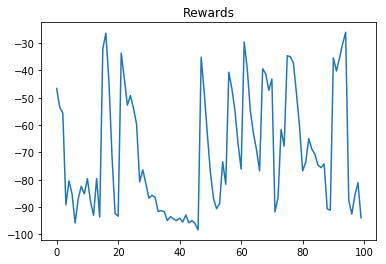

In [21]:
if __name__ == '__main__':
    main()